# <center>**Classification of Unraveled Spirals**<center>

#### **Goal:** obtain a distance error between the misclassified hand drawn spirals and a LOBF ("ideal") spiral

Any functions / processes that require the use of tensorflow or keras need to be in this file. Other functions can be in a seperate python file. 

## **Process**
1. Import the skeletonized images
    - Convert to grayscale
    - Save all images in an array with the corresponding labels
2. Unravel all of the spirals
    - Normalize so they all have the same length
        - Do this by zero-padding?
3. Perform spline fitting
    - Subtract the spline from hand-drawing
    - This is the "deviation signal"
    - Convert to the frequency domain
        - Take the fft
        - Plot the magnitude of a couple of the spirals
5. Extract features
    - Need to decide what will be passed in as features for classification
        - variance, SNR, bandwidth, peaks, center freq?
6.  Run features through classifiers
    - RF, SVM, NB, KNN


In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import warnings
import seaborn as sns

# import ML libraries
from sklearn import utils, svm, metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.interpolate import UnivariateSpline 

# import files with certain functions
from code_files.archSpiral import * # functions of interest are 'unravelSpiral' and 'calcDist_to_center' 

warnings.filterwarnings('ignore')

c:\Users\Rebecca\anaconda3\envs\MLEnv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## <center>Step 1: Import Skeletonized Images<center>

size of imgs array:  (61, 1000, 1000)
size of lbls array:  (61,)


<AxesSubplot:ylabel='count'>

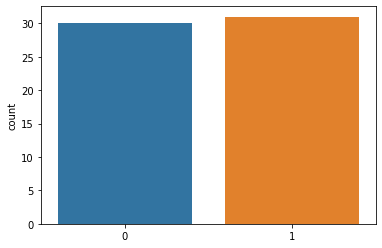

In [2]:
dir = os.getcwd()
folder_path = dir + '/datasets/folador_skeletonize/skeletons/spirals/'

imgs = [] # create empty array to store all the images
lbls = [] # create empty array to store the labels of the images
for img_name in os.listdir(folder_path):
    img_path = os.path.join(folder_path, img_name)
    img = cv2.imread(img_path)
    
    # convert to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # save image in 'imgs' array
    imgs.append(img)

    # save the labels in 'lbls' array
    # need to determine if it is healthy or parkinsons based on 'H' or 'P' being present in the file name
    if 'H' in img_name:
        lbls.append(0)
    else:
        lbls.append(1)

# shuffle the data
# imgs, lbls = utils.shuffle(imgs, lbls)

print("size of imgs array: ", np.shape(imgs))
print("size of lbls array: ", np.shape(lbls))

# plot the distribution of labls
sns.countplot(lbls)

## <center>Step 2: Unravel Spirals<center>

In [3]:
numImgs = len(imgs)
unraveledSpirals = [] # create empty array to store unraveled spirals

# iterate through all images and unravel
for i in range(numImgs):
    center = unravelSpiral(imgs[i])
    unravelledImg = calcDist_to_center(imgs[i], center)
    unraveledSpirals.append(unravelledImg)

print(np.shape(unraveledSpirals))

# then need to normalize (do by zero padding)

(61,)


## <center>Step 3: Perform Spline Fitting<center>

0


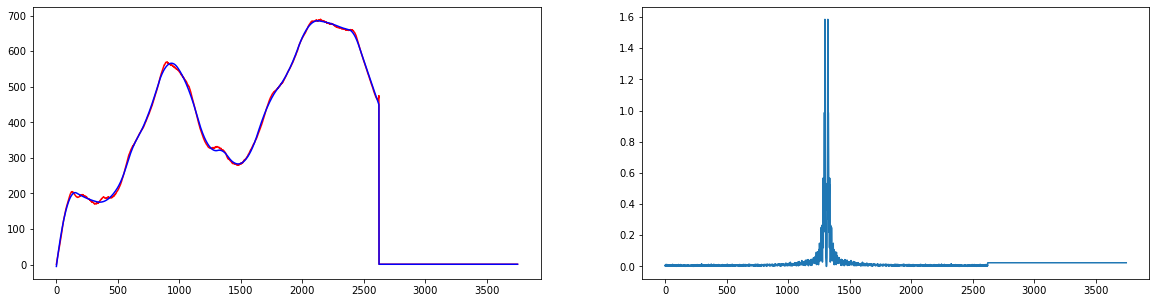

0


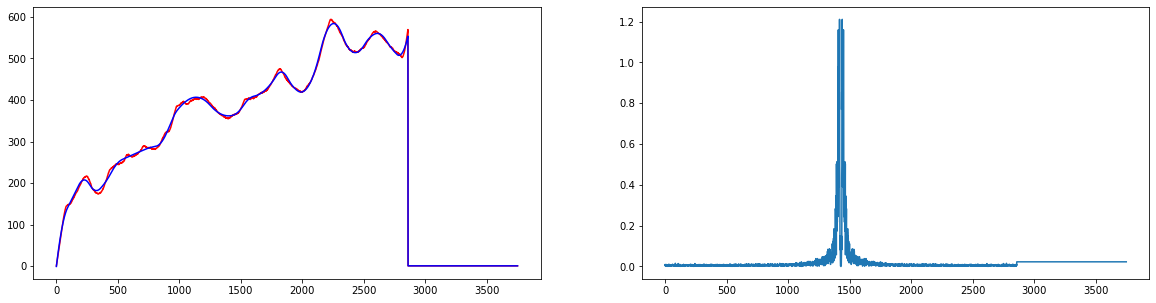

0


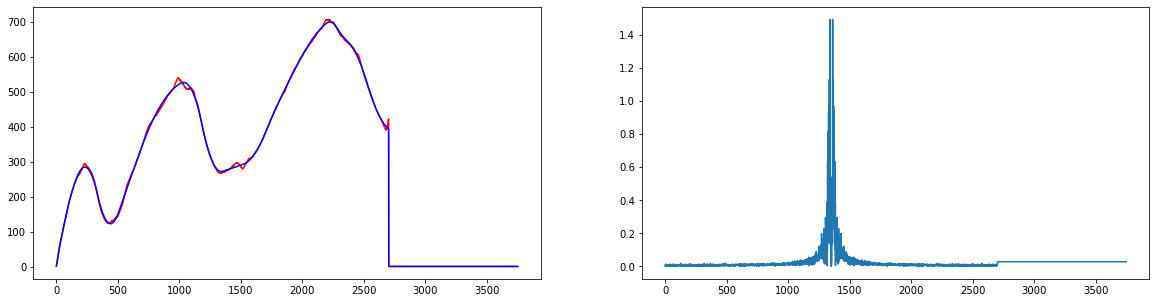

1


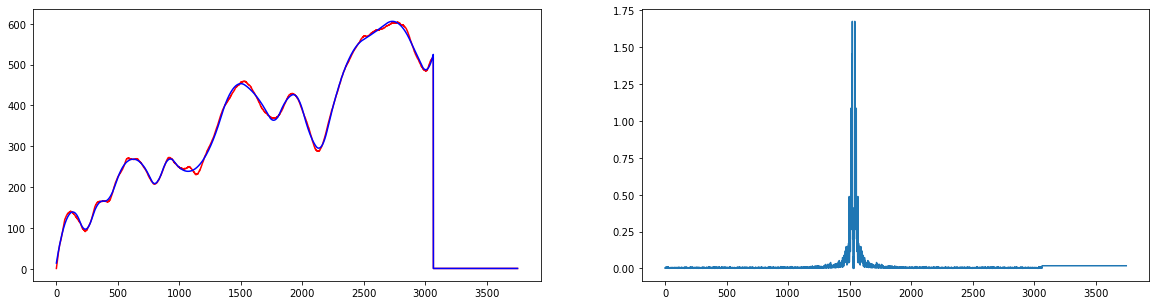

1


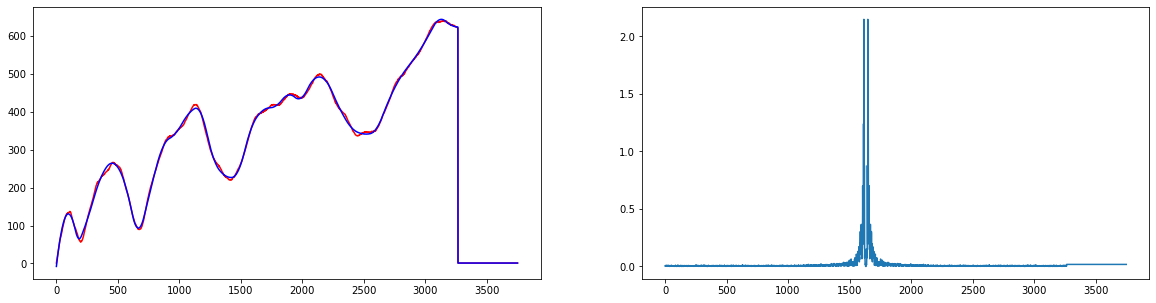

0


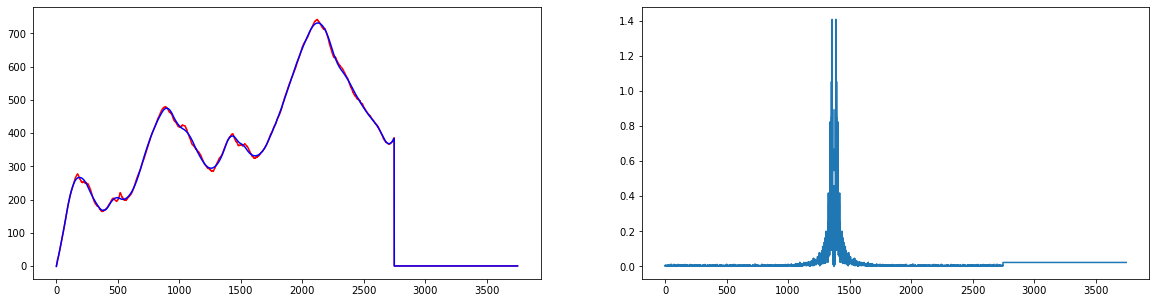

0


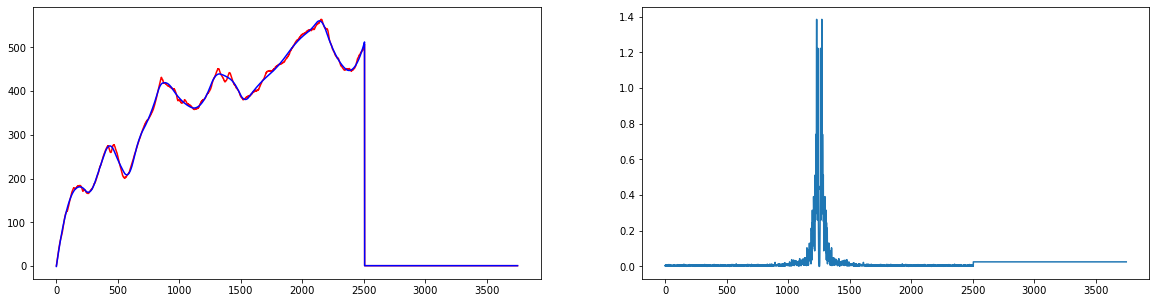

0


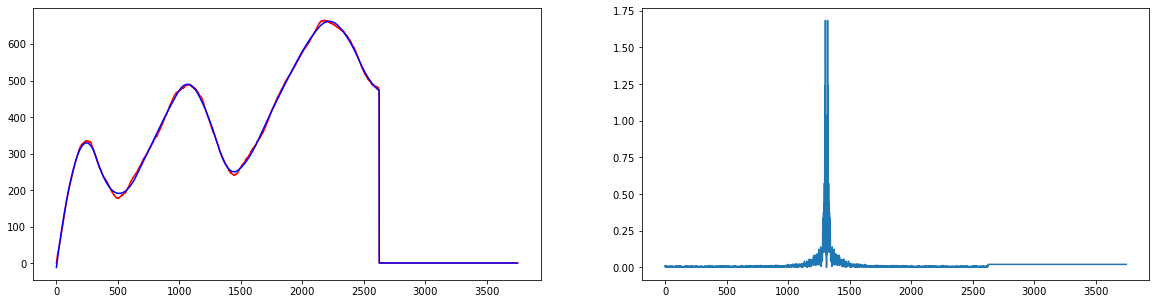

0


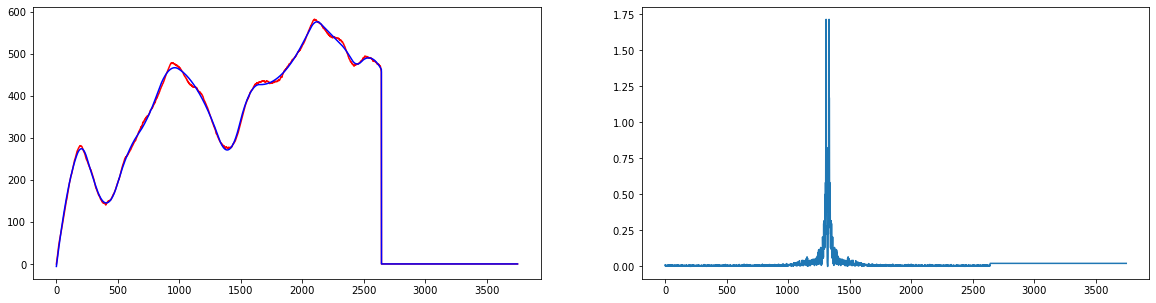

1


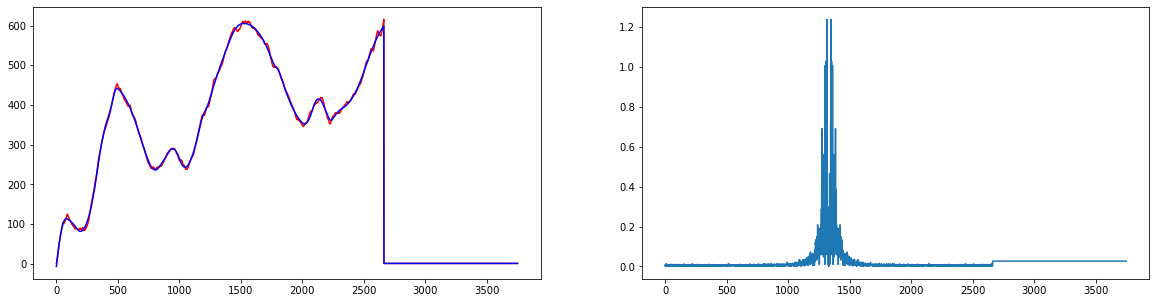

1


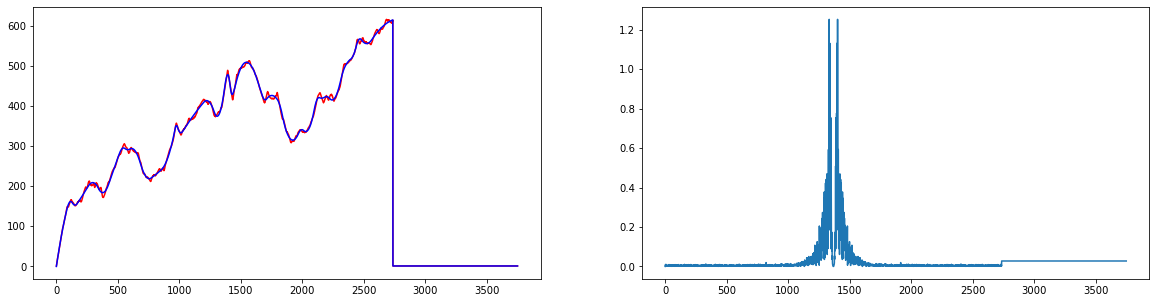

1


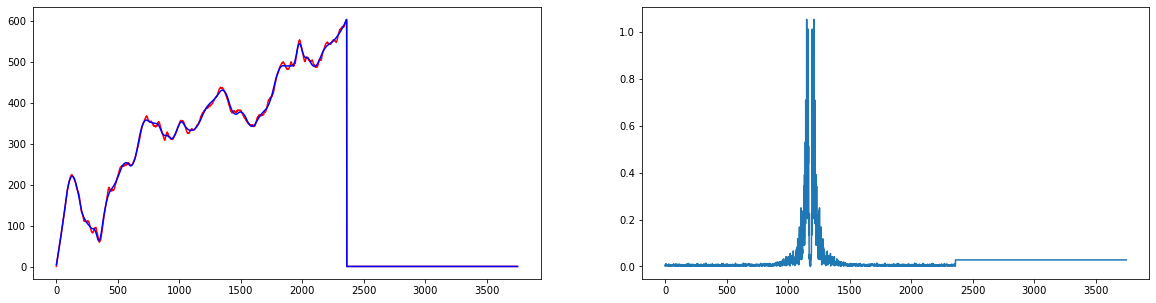

1


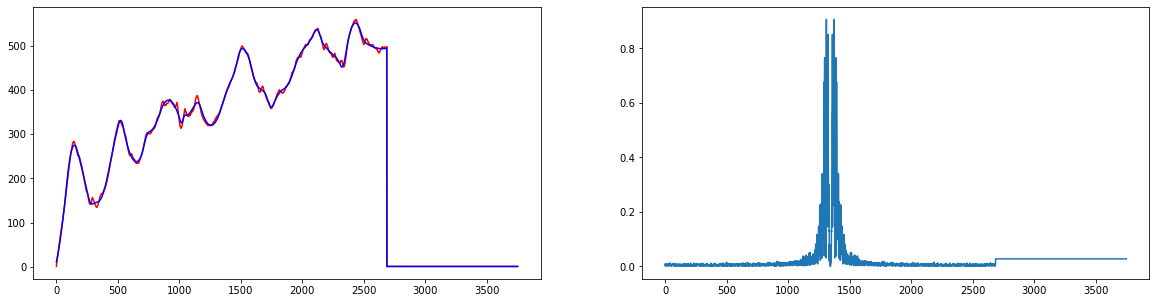

1


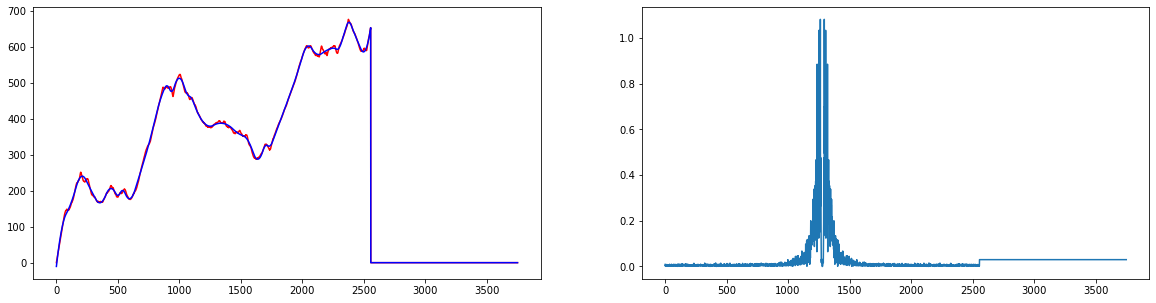

1


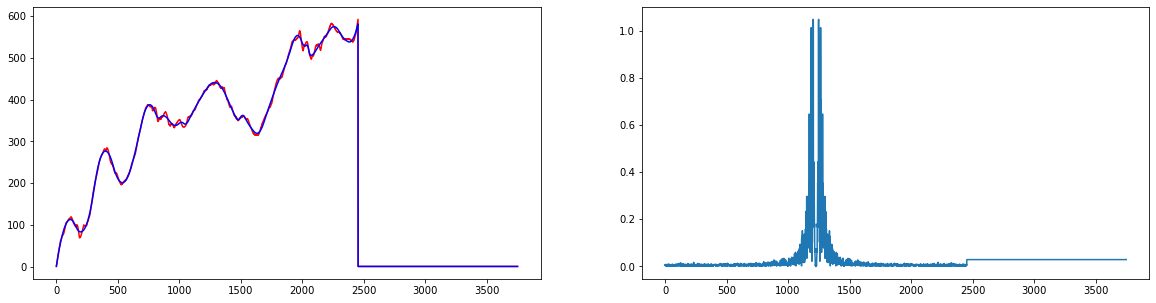

In [6]:
fftSignals = [] 

# iterate through all the unravelled spirals
# fit a spline to each spiral individually
# subtract the spline from the hand-drawing
# store this difference signal in 'deviationSignals'
for i in range(15):
    print(lbls[i])

    hand_drawing = unraveledSpirals[i][::2]
    numSamples = np.linspace(0, len(hand_drawing)-1, len(hand_drawing))    

    pad_width = 3750 - len(hand_drawing)
    pad_array = np.ones(pad_width).astype(np.int) 


    # calculate the line-of-best-fit (LOBF) or "spline"
    spl = UnivariateSpline(numSamples, hand_drawing, s=len(numSamples)*25, k=2)
    lobf = spl(numSamples)

    # plt.plot(hand_drawing)
    # plt.plot(lobf)
    # plt.show()

    # take the difference
    diff = hand_drawing - lobf
    
    # take the magnitude of the fft to convert to the frequency domain
    diff = (np.abs(np.fft.fftshift(np.fft.fft(diff)) / len(hand_drawing)))
    mean = np.mean(diff)
    diff = np.append(diff, (pad_array * mean))

    fftSignals.append(diff)
    
    xaxis = np.linspace(0, 3750-1, 3750)
    yaxis = np.append(hand_drawing, pad_array)
    lobf = np.append(lobf, pad_array)

    fig, ax = plt.subplots(1,2,figsize=(20,5))
    ax[0].plot(xaxis, yaxis, label="data", color='r')
    ax[0].plot(xaxis, lobf, label="LOBF", color='b')
    ax[1].plot(xaxis, diff)
    plt.show()

## <center>Step 4: Extract Features<center>

In [7]:
# SNR, variance, BW, center freq, peaks

# obtain the magnitude
peaks = []
centers = []
var = []
snr = []

for i in range(numImgs):
    sig = np.around(fftSignals[i], decimals=10) # round the values to 10 decimal places
    max = np.max(sig) # calculate the peak

    # find the "center freq" location
    peak_loc = np.argwhere(sig == max) 
    center_loc = peak_loc[0] + int((peak_loc[1] - peak_loc[0])/2)

    # calculate the variance
    sigVar = np.var(sig)

    # calculate SNR
    avg = np.mean(sig)
    std_dev = np.std(sig)
    sigSNR = np.where(std_dev == 0, 0, avg/std_dev)

    peaks.append(max)
    centers.append(center_loc)
    var.append(sigVar)
    snr.append(sigSNR)

In [8]:
# calculate the bandwidth (BW)
bw = []

for i in range(numImgs):
    sig = fftSignals[i]
    noise_floor = np.mean(sig)*2

    numSamples = np.linspace(0, len(sig)-1, len(sig))  
    spl = UnivariateSpline(numSamples, sig, s=.1)
    lobf = spl(numSamples)  
    
    lobf_approx = np.around(lobf, 3) 
    nf_approx = np.around(noise_floor,3)
    diff = np.around(np.abs(lobf_approx - nf_approx),3)
    intersectsNF = np.argwhere(diff <= 0.002)
    bw.append(intersectsNF[-1] - intersectsNF[0])


[192] 0


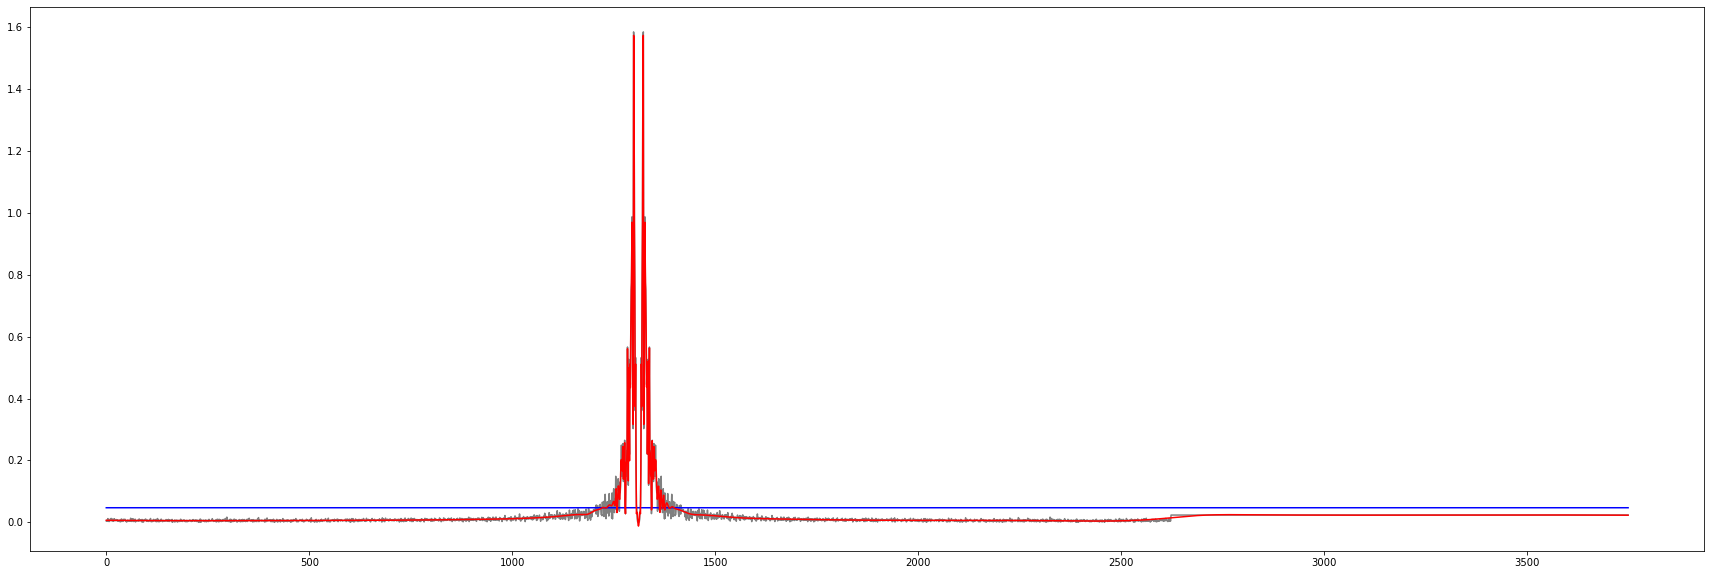

In [9]:
for i in range(1):
    print(bw[i], lbls[i])
    sig = fftSignals[i]
    numSamples = np.linspace(0, len(sig)-1, len(sig))  
    spl = UnivariateSpline(numSamples, sig, s=.15)
    lobf = spl(numSamples)  
    
    plt.figure(figsize=(30,10))
    plt.plot(xaxis, sig, color='gray')
    plt.plot(xaxis, np.ones(3750).astype(np.int)*np.mean(sig)*2, color='blue')
    plt.plot(xaxis, lobf, color='red')
    plt.show()

## <center>Step 5: Run Features Through Classifier<center>

In [82]:
# first put all the features in a dataframe

# try classifying with SVM
# https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python 

In [10]:
fft_features = {'labels':lbls,'peaks': peaks, 'centers':centers, 'variance':var, 'SNR':snr, 'BW':bw}
fft_df = pd.DataFrame(fft_features)
fft_df.head()

# save as csv 
fft_df.to_csv('fft_df.csv', index=False)
# fft_raw = {'fft_data': fftSignals, 'labels':lbls}
# fft_raw = pd.DataFrame(fft_raw)
# fft_raw.head()


In [11]:
x_train, x_test, y_train, y_test = train_test_split(fft_df.drop(['labels'], axis=1), fft_df.labels, test_size=.2, stratify=fft_df.labels) #'peaks', 'variance', 'SNR'

<AxesSubplot:xlabel='labels', ylabel='count'>

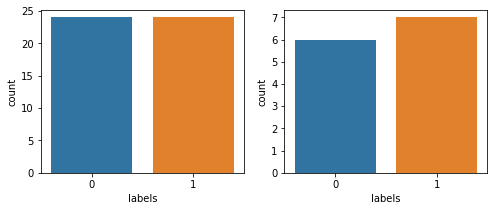

In [12]:
fig, ax = plt.subplots(1,2, figsize=(8,3))
sns.countplot(y_train, ax=ax[0])
sns.countplot(y_test, ax=ax[1])

In [13]:
clf = svm.SVC(kernel='poly')
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.46153846153846156


In [14]:
# create SVM classifier
def SVM_classifier(train_data, train_labels, val_data, val_labels):

    #clf = svm.SVC(kernel='poly', degree=5)
    param_grid={'C':[0.1,5,10,100],'degree':[2,5,7,10],'kernel':['rbf','poly']}
    clf = svm.SVC(probability=True)
    model = GridSearchCV(clf, param_grid)

    # train model
    #clf.fit(train_data, train_labels)
    model.fit(train_data, train_labels)

    model.best_params_
    print(model.best_params_)

    # predict the model
    pred = (model.predict(val_data))

    # calculate accuracy
    acc = round(metrics.accuracy_score(pred, val_labels),4)

    print("The predicted data is: ", pred)
    print("The actual data is: ", np.array(val_labels))
    print(f"The model is {acc*100}% accurate")

    return acc, pred

svm_acc = []

for ii in range(0,10):
    temp_acc, svm_pred = SVM_classifier(x_train, y_train, x_test, y_test)
    svm_acc.append(temp_acc)

print("Average accurage: ", np.mean(svm_acc))

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

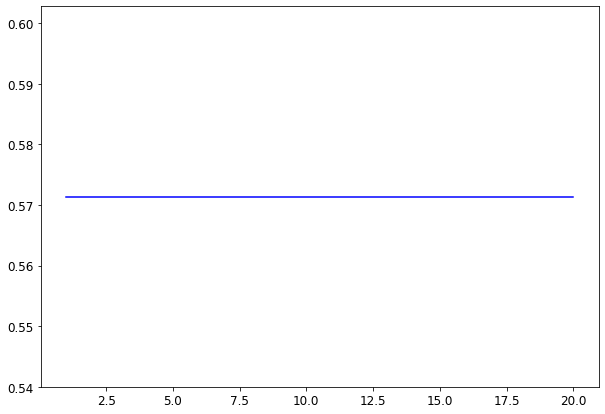

In [223]:
## Plotting
num_tests = np.linspace(1,len(svm_acc), len(svm_acc))

plt.figure(2)
plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 12})

plt.plot(num_tests, svm_acc, 'b')
plt.show()

### Random Forest

In [48]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.6923076923076923
